# Image Data Capture

Data from Execution Rocks Weather Buoy is unreliable. NWS doesn't store the data in whatever form. For our purposes we could use the data anyway as we are only interested in realtime readings not modelling reliability. The buoy access point is supposed to supply this data but we can't access it. So I have to try to OCR the fixed data locations an begin to build our own database.  This sheet is a model for the capture.

The website is: `https://lisicos.uconn.edu/stn_exrx.php`

The image is: `<img src="https://clydebank.dms.uconn.edu/exrx_wxSens2.png" alt="Execution Rocks Weather Panel" border="1" style="border: 1px solid #999999;">`

<img src="https://clydebank.dms.uconn.edu/exrx_wxSens2.png?4" alt="Execution Rocks Weather Panel" border="1" style="border: 1px solid #999999;">
*Hint: change the number after the '?' to force a refresh.*

The steps are to first build and test the components of the tool to extract the data and then develop an object for doing this on the fly.
The current plan is to create a class that does this and to run it once every 15 minutes to collect the data in a circular buffer 24 hours long that will then be used to fuel an existing graphing tool for windspeed and direction. There is a lot of other information we can collect, like wave height, which may also be included in the graph.

In [2]:
"""
General imports needed.
"""
# foundational libraries
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
import pytz  # may need to migrate to ZoneInfo
import requests
import logging

# OCR tools
import pytesseract
# Bridge to cli tool. Need to install tesseract CLI engine in the OS

# Managing images
from PIL import Image

# Data management
import numpy as np
import pandas as pd

## Build and test components

### Image Retrieval
 - `get_and_store_png` is good for any of the NERACOOS images.

In [2]:
"""
This is the method we use to retrieve the image

"""
import requests
import numpy as np


def get_and_store_png(url, filename="image.png"):
    """
        :param url: URL to retrieve the image (expect a png)
        :param url: filename to store the image.  We may implement a memory store option.
        :return:    filepath (or maybe PIL object?)
    """
    # 1. Retrieve the image
    response = requests.get(url)
    
    # Check if the request was successful (HTTP 200)
    if response.status_code == 200:
        # 2. Store to disk for a second step
        with open(filename, "wb") as f:
            f.write(response.content)
        return filename  # Return path to the stored file
    else:
        raise Exception(f"Failed to retrieve image. Status code: {response.status_code}")

# Example usage
# image_url = "https://clydebank.dms.uconn.edu/exrx_wxSens2.png"
# stored_path = get_and_store_png(image_url)
# Second step: use 'stored_path' to process the image


### Process the image using the **P**ython **I**mage **L**ibrary
tools extracting and preparing the pieces of the image for OCR recognition.
 - `preprocess_for_ocr` tweaks the image to insure more reliable OCR
 - `extract_regions` extract the desired region for OCR

In [57]:
from PIL import Image

def preprocess_for_ocr(croppedImage):
    """
    Improve the image for the OCR process.
    :param croppedImage: an image object retrieved from the cropping process.
    :return: adapted image for OCR step
    """
    # 1. Convert to Grayscale ('L' mode in Pillow)
    gray_crop = croppedImage.convert('L')
    
    # 2. Resize: Tesseract needs clear, large characters. 
    # Upscaling by 2x or 3x often fixes issues with small regions.
    w, h = gray_crop.size
    upscaledImage = gray_crop.resize((w * 2, h * 2), Image.Resampling.LANCZOS)
    
    # 3. Optional: Invert if text is light on a dark background
    # Tesseract expects dark text on a light background.
    # upscaled = ImageOps.invert(upscaled) 
    return upscaledImage

def extract_regions(image_path, regions):
    """
    Extracts multiple rectangular regions from a PNG.  Again, we store the result 
    on disk but maybe we can get away with memory?
    :param image_path: Path to the retrieved PNG file.
    :param regions: List of 4-tuples (left, upper, right, lower) coordinates.
    :return: List of cropped Image objects.
    """
    extracted_images = []
    
    with Image.open(image_path) as img:
        # Standardize for OCR: convert to RGB and remove transparency
        img = img.convert("RGB") 
        
        for i, box in enumerate(regions):
            # box = (left, upper, right, lower)
            # Example: (10, 10, 100, 50) extracts a 90x40 pixel area
            crop = preprocess_for_ocr(img.crop(box))
            
            # Optional: Store locally for debugging or the second step
            crop.save(f"region_{i}.png")
            extracted_images.append(crop)
            
    return extracted_images

# Example usage:
# Coordinates for two different fields on your document
# target_areas = [(50, 100, 200, 150), (300, 400, 450, 480)]
# croppedImages = extract_regions("image.png", target_areas)

### displayImages
A quick and dirty tool to display processed images prior to OCR. Intended for debugging
 - `display_extracted_regions`
 - Also demos how we can do this without a program.

In [ ]:

def display_extracted_regions(croppedImages, titles=None):
    """
    Displays a list of PIL image crops in a Matplotlib grid.
    :param croppedImages: a list of cropped images 
    :param title: optional titles.
    """
    num_crops = len(croppedImages)
    # Create a grid: 1 row, multiple columns
    fig, axes = plt.subplots(1, num_crops, figsize=(15, 5))
    
    # Handle case with only one crop (axes won't be an array)
    if num_crops == 1:
        axes = [axes]
        
    for i, crop in enumerate(croppedImages):
        # print(f"\tDBG: {i:02d}, {titles[i]}: {len(crop)}")
        axes[i].imshow(crop, cmap='gray')
        axes[i].axis('off')  # Hide pixel coordinates for OCR preview
        if titles:
            axes[i].set_title(titles[i])
            
    plt.tight_layout()
    plt.show()

# Example usage with crops from your previous step
# display_extracted_regions(croppedImages, titles)

<!-- <img src="./region0.png" align="left">  <img src="./region1.png" align="right">
<img src="./region2.png" align="left">  <img src="./region3.png" align="right">
<img src="./region4.png" align="left">  <img src="./region5.png" align="right"> -->
<!-- ```
titles = ["windSpeedKtsAvg", "windSpeedKtsGst", "windDirTrue",
           "windSpeedMphAvg", "windSpeedMphGst",
           "airTempFar", "airTempCent",
           "baromPresTorr", "baromPresmBar", 
           "dateString"]
``` -->
|c1|c2|c3|
|:-:|:-:|:-:|
|"windSpeedKtsAvg"|"windSpeedKtsGst"|"windDirTrue"|
|![windSpeedKtsAvg](region_0.png)|![windSpeedKtsGst](region_1.png)|![windDirTrue](region_2.png)|
|"windSpeedMphAvg"|"windSpeedMphGst"|
|![windSpeedMphAvg](region_3.png)|![windSpeedMphGst](region_4.png)||
|"airTempFar"|"airTempCent"||
|![airTempFar](region_5.png)|![airTempCent](region_6.png)||
|"baromPresTorr"|"baromPresmBar"||
|![baromPresTorr](region_7.png)|![baromPresmBar](region_8.png)||
|"dateString"|||
|![dateString](region_9.png)|||


### Manually define the regions of interest
Open a copy of the NERACOOS image in Gimp and define the rectangles that encapsulate 
the data we want to capture. Eventually this will find its way into a common data structure.

 - Curate the capture regions and data.
 - Develop the data structure for containing the data

In [ ]:
## Preliminary exercise. final values are redefined below.
windSpeedKtsAvg = (21, 307, 63, 327)   #kts
windSpeedKtsGst = (116, 307, 158, 327) #kts
windSpeedMphAvg = (21, 334, 63, 351)   #mph
windSpeedMphGst = (116, 334, 158, 351) #mph
windDirTrue     = (230, 320, 287, 339) #deg True
airTempFar      = (410, 169, 471, 188) #degFarenheit
airTempCent     = (409, 221, 471, 238) #degCentegrade
baromPresTorr   = (391, 415, 449, 434) #barm in mmHg
baromPresmBar   = (467, 415, 537, 434) #barm in mBar
dateString      = (100, 64, 294, 78) #dateString

regions = [windSpeedKtsAvg, windSpeedKtsGst, windDirTrue,
           windSpeedMphAvg, windSpeedMphGst,
           airTempFar, airTempCent,
           baromPresTorr, baromPresmBar, dateString]

titles = ["windSpeedKtsAvg", "windSpeedKtsGst", "windDirTrue",
           "windSpeedMphAvg", "windSpeedMphGst",
           "airTempFar", "airTempCent",
           "baromPresTorr", "baromPresmBar", 
           "dateString"]

# crops = extract_regions("image.png", regions)

### Do the OCR of the regions and test the tweaking sercrets

 - `ocr_numerals_only` limit our recognition to floats with or without minus signs.

In [28]:
import pytesseract
# Need to install tesseract

def ocr_numerals_only(image_crops):
    """
    Processes image crops to extract only numbers and decimal points.
    :param image_crops: List of PIL Image objects (from previous step).
    :return: List of extracted numeric strings.
    """
    # Configuration breakdown:
    # --psm 6: Assume a single uniform block of text (good for small crops)
    # tessedit_char_whitelist: Restrict characters to digits and dot
    custom_config = r'--psm 6 -c tessedit_char_whitelist=-0123456789.'
    
    extracted_data = []
    for crop in image_crops:
        # Perform OCR
        text = pytesseract.image_to_string(crop, config=custom_config)
        # Clean up whitespace/newlines
        extracted_data.append(text.strip())
        
    return extracted_data

# Example usage
numeric_values = ocr_numerals_only(crops)
print(f"\tDBG: Extracted values: {numeric_values}")
for i, valueStr in enumerate(numeric_values):
    val = float(valueStr)
    print(f"\tDBG: {titles[i]}:\t{val:10.1f}")

Extracted values: ['6.9', '10.5', '288', '7.9', '12.0', '23.2', '4.9', '29.87', '1011.64', '113000.01']
windSpeedKtsAvg:	       6.9
windSpeedKtsGst:	      10.5
windDirTrue:	     288.0
windSpeedMphAvg:	       7.9
windSpeedMphGst:	      12.0
airTempFar:	      23.2
airTempCent:	       4.9
baromPresTorr:	      29.9
baromPresmBar:	    1011.6
dateString:	  113000.0


Quick test to see if we can capture the date string as well.

In [33]:
pytesseract.image_to_string(crops[-1], config=r'--psm 6 -c tessedit_char_whitelist=-0123456789,:\ APMSunMonTueEdThuFriSatJanFebMarAprMayJunJulAugSepOctNovDec')

'11:30:00 PM EST, Thu Jan 01\n'

### Pulling it all together
We need to install the following on the Raspberry Pi:
```bash
# install 
sudo pip install PIL

# Update package lists
sudo apt update

# Install the Tesseract OCR engine
sudo apt install -y tesseract-ocr

# Install Python dependencies
pip3 install pytesseract Pillow
```

## Libraries

In [13]:
"""
General imports needed.
"""
# foundational libraries
import os
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
import pytz  # may need to migrate to ZoneInfo
import requests

# OCR tools
import pytesseract
# Bridge to cli tool. Need to install tesseract CLI engine in the OS

# Managing images
from PIL import Image

# Data management
import numpy as np
import pandas as pd


### Global Structures and Configurations
# Timezone configuration OLD SCHOOL
UTC = pytz.utc
# EST = pytz.timezone('US/Eastern')
# Timezone configuration NEW SCHOOL
# UTC = ZoneInfo.utc
EST = ZoneInfo('US/Eastern')

## Basic Information Tables

In [48]:
# Global defintion of no data.
NaN = float('nan')

# image URIs for Wind information
execrocksWind_url = "https://clydebank.dms.uconn.edu/exrx_wxSens2.png"  # Execution rocks
westernLIWind_url = "https://clydebank.dms.uconn.edu/wlis_wxSens1.png"  # Western Long Island

# dictionary of locations within the image of the data we want.
windSources = {
    'Timestamp':          {'bounds':(100,  62, 294,  78), 'value': NaN }, #dateString for reading
    'WindSpeedAvg [kts]': {'bounds':( 21, 307,  63, 327), 'value': NaN,}, #kts
    'WindSpeedGst [kts]': {'bounds':(116, 307, 158, 327), 'value': NaN }, #kts
    'WindSpeedAvg [mph]': {'bounds':( 21, 334,  63, 351), 'value': NaN }, #mph
    'WindSpeedGst [mph]': {'bounds':(116, 332, 158, 351), 'value': NaN }, #mph
    'WindSpeedAvg [m/s]': {'bounds':(21, 358, 63, 375),   'value': NaN }, #m/s
    'WindSpeedGst [m/s]': {'bounds':(116, 358, 158, 375), 'value': NaN }, #m/s
    'WindDir [°]':        {'bounds':(230, 320, 287, 339), 'value': NaN }, #deg True
    'AirTemp [°F]':       {'bounds':(410, 169, 471, 188), 'value': NaN }, #degFarenheit
    'AirTemp [°C]':       {'bounds':(409, 221, 471, 238), 'value': NaN }, #degCentegrade
    'BaromPres [mmHg]':   {'bounds':(391, 415, 449, 434), 'value': NaN }, #barm in mmHg
    'BaromPres [mB]':     {'bounds':(467, 415, 537, 434), 'value': NaN }, #barm in mBar
    'DewPoint [°F]':      {'bounds':(505, 322, 552, 341), 'value': NaN }, #dewpoint degFarenheit
    'DewPoint [°C]':      {'bounds':(563, 322, 605, 341), 'value': NaN }, #dewPoint degCentegrade
    'RelHum [%]':         {'bounds':(391, 323, 448, 341), 'value': NaN }, #rel. humidity
    'WindSpeedM24 [kt]':  {'bounds':(112, 412, 150, 435), 'value': NaN }, #kts max in last 24hrs
    'WindDirM24 [°]':     {'bounds':(271, 412, 300, 433), 'value': NaN }, #deg True in last 24hrs
    'WindTimeM24':        {'bounds':(114, 433, 299, 454), 'value': NaN }, #dateString of 24Hr Max
}

# image URIs for Wave information
westernLIWaves_url = "https://clydebank.dms.uconn.edu/wlis_wavs.png" 
execrocksWaves_url = "https://clydebank.dms.uconn.edu/exrx_wavs.png"

# dictionary of locations within the image of the data we want.
waveSources = {
    'Timestamp':         {'bounds':(100,  62, 294,  78), 'value': NaN },  #dateString for reading
    'WaveHgtSig [ft]':    {'bounds':( 68, 329, 112, 346), 'value': NaN,}, #ft
    'WaveHgtMax [ft]':    {'bounds':(168, 329, 212, 346), 'value': NaN }, #ft
    'WaveHgtSig [m]':     {'bounds':( 68, 353, 112, 371), 'value': NaN,}, #m
    'WaveHgtMax [m]':     {'bounds':(168, 353, 212, 371), 'value': NaN }, #m
    'WaveDir [°]':        {'bounds':(292, 322, 347, 340), 'value': NaN }, #degT
    'WavPerAvg [s]':      {'bounds':(479, 193, 539, 211), 'value': NaN }, #sec
    'WavPerDom [s]':      {'bounds':(479, 251, 539, 269), 'value': NaN }, #sec
    'WaveHgt24 [ft]':     {'bounds':(169, 413, 207, 430), 'value': NaN }, #kts max in last 24hrs
    'WaveDirM24 [°]':     {'bounds':(327, 412, 354, 430), 'value': NaN }, #deg True in last 24hrs
    'WavePerAvgM24 [s]':  {'bounds':(440, 412, 468, 430), 'value': NaN }, #avg period in last 24hrs
    'WaveperDomM24 [s]':  {'bounds':(540, 412, 570, 430), 'value': NaN }, #dom period in last 24hrs
    'WaveTimeM24':        {'bounds':(169, 433, 363, 455), 'value': NaN }, #dateString of 24Hr Max  
}


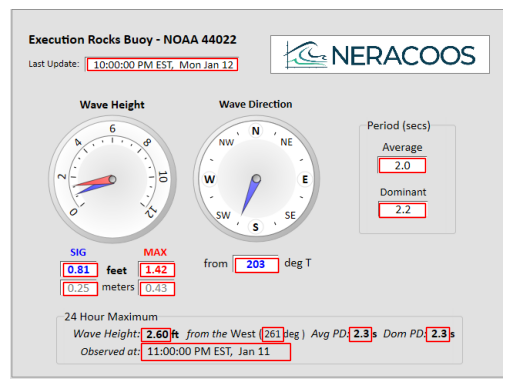

In [49]:
import io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def getURLImage(url):
    """
    Retrieves an image from a URL and converts it to a PIL Image object.
    :param url: URL of the image to retrieve.
    :return: PIL Image object.
    """
    response = requests.get(url)
    if response.status_code == 200:
        image_data = response.content
        image = Image.open(BytesIO(image_data))
        return image
    else:
        raise Exception(f"Failed to retrieve image. Status code: {response.status_code}")

def overlayRectangles(axs, regions):
    """
    Overlays rectangles on the given axes for the specified regions.
    :param axs: Matplotlib axes to draw on.
    :param regions: List of 4-tuples (left, upper, right, lower) coordinates.
    """
    for key, item in regions.items():
        left, upper, right, lower = item['bounds']
        width = right - left
        height = lower - upper
        rect = patches.Rectangle((left, upper), width, height, linewidth=1, edgecolor='r', facecolor='none')
        axs.add_patch(rect)

def display_image(image):
    """
    Displays a PIL image using Matplotlib.
    :param image: PIL Image object to display.
    """
    fig, ax = plt.subplots()
    ax.imshow(image)
    # overlayRectangles(ax, windSources)
    overlayRectangles(ax, waveSources)
    ax.axis('off')  # Hide pixel coordinates
    plt.show()

img = getURLImage(execrocksWaves_url)
display_image(img)


## Build the OCR Class
 - organize the desired fields into a dictioanary
 - collect the above methods into a class.
 - refactor the methods for efficiency and maintenace.

In [ ]:
"""
    Quick review: NERACOOS weather buoys are managed by the Univ. of Ct. Bridgeport. They have invested, 
    heavily in a package (software and hardware) that provides real-time data on wind, waves and water 
    quality for LI Sound. We are most interested in two buoys which are close by to our harbor:
    Execution Rocks [exrx] and Western LI Sound [wlis]. The devices with their software can deliver csv lists
    of their systems but it would appear that the servers that present the data are not set up for this or
    not properly installed.  Since trying to access this infomation doesn't resolve to a permissions error
    or a no-authorized response but just a blunt php crash I am assuming the later.

    Our only option is to read the data from the .png graphical screens that are presented on their
    website. Fortunately this is pretty straightforward. In addition the data is only updated every 15 minutes
    for the Wind information and 20min for wave information.  Pulling data once every 10min seems like an
    easy lift.
"""

########################################### USER CONFIGURABLES #######################################
# Global defintion of no data.
NaN = float('nan')

# image URIs for Wind information
execrocksWind_url = "https://clydebank.dms.uconn.edu/exrx_wxSens2.png"  # Execution rocks
westernLIWind_url = "https://clydebank.dms.uconn.edu/wlis_wxSens1.png"  # Western Long Island

# dictionary of locations within the image of the data we want.
windSources = {
    'Timestamp':          {'bounds':(100,  62, 294,  78), 'value': NaN }, #dateString for reading
    'WindSpeedAvg [kts]': {'bounds':( 21, 307,  63, 327), 'value': NaN,}, #kts
    'WindSpeedGst [kts]': {'bounds':(116, 307, 158, 327), 'value': NaN }, #kts
    'WindSpeedAvg [mph]': {'bounds':( 21, 334,  63, 351), 'value': NaN }, #mph
    'WindSpeedGst [mph]': {'bounds':(116, 332, 158, 351), 'value': NaN }, #mph
    'WindSpeedAvg [m/s]': {'bounds':( 21, 358,  63, 375), 'value': NaN }, #m/s
    'WindSpeedGst [m/s]': {'bounds':(116, 358, 158, 375), 'value': NaN }, #m/s
    'WindDir [°]':        {'bounds':(230, 320, 287, 339), 'value': NaN }, #deg True
    'AirTemp [°F]':       {'bounds':(410, 169, 471, 188), 'value': NaN }, #degFarenheit
    'AirTemp [°C]':       {'bounds':(409, 221, 471, 238), 'value': NaN }, #degCentegrade
    'BaromPres [mmHg]':   {'bounds':(391, 415, 449, 434), 'value': NaN }, #barm in mmHg
    'BaromPres [mB]':     {'bounds':(467, 415, 537, 434), 'value': NaN }, #barm in mBar
    'DewPoint [°F]':      {'bounds':(505, 322, 552, 341), 'value': NaN }, #dewpoint degFarenheit
    'DewPoint [°C]':      {'bounds':(563, 322, 605, 341), 'value': NaN }, #dewPoint degCentegrade
    'RelHum [%]':         {'bounds':(391, 323, 448, 341), 'value': NaN }, #rel. humidity
    'WindSpeedM24 [kt]':  {'bounds':(112, 412, 150, 435), 'value': NaN }, #kts max in last 24hrs
    'WindDirM24 [°]':     {'bounds':(271, 412, 300, 433), 'value': NaN }, #deg True in last 24hrs
    'WindTimeM24':        {'bounds':(114, 433, 299, 454), 'value': NaN }, #dateString of 24Hr Max
}

# image URIs for Wave information
westernLIWaves_url = "https://clydebank.dms.uconn.edu/wlis_wavs.png" 
execrocksWaves_url = "https://clydebank.dms.uconn.edu/exrx_wavs.png"

# dictionary of locations within the image of the data we want.
waveSources = {
    'Timestamp':          {'bounds':(100,  62, 294,  78), 'value': NaN },  #dateString for reading
    'WaveHgtSig [ft]':    {'bounds':( 68, 329, 112, 346), 'value': NaN,}, #ft
    'WaveHgtMax [ft]':    {'bounds':(168, 329, 212, 346), 'value': NaN }, #ft
    'WaveHgtSig [m]':     {'bounds':( 68, 353, 112, 371), 'value': NaN,}, #m
    'WaveHgtMax [m]':     {'bounds':(168, 353, 212, 371), 'value': NaN }, #m
    'WaveDir [°]':        {'bounds':(292, 320, 347, 340), 'value': NaN }, #degT
    'WavPerAvg [s]':      {'bounds':(479, 193, 539, 211), 'value': NaN }, #sec
    'WavPerDom [s]':      {'bounds':(479, 251, 539, 269), 'value': NaN }, #sec
    'WaveHgt24 [ft]':     {'bounds':(169, 413, 207, 433), 'value': NaN }, #kts max in last 24hrs
    'WaveDirM24 [°]':     {'bounds':(327, 412, 354, 433), 'value': NaN }, #deg True in last 24hrs
    'WavePerAvgM24 [s]':  {'bounds':(440, 412, 468, 430), 'value': NaN }, #avg period in last 24hrs
    'WaveperDomM24 [s]':  {'bounds':(540, 412, 570, 430), 'value': NaN }, #dom period in last 24hrs
    'WaveTimeM24':        {'bounds':(169, 433, 363, 455), 'value': NaN }, #dateString of 24Hr Max  
}
########################################### USER CONFIGURABLES #######################################


In [16]:
list(windSources.keys())

['WindSpeedAvg [kts]',
 'WindSpeedGst [kts]',
 'WindSpeedAvg [mph]',
 'WindSpeedGst [mph]',
 'WindSpeedAvg [m/s]',
 'WindSpeedGst [m/s]',
 'WindDir [°]',
 'AirTemp [°F]',
 'AirTemp [°C]',
 'BaromPres [mmHg]',
 'BaromPres [mB]',
 'DewPoint [°F]',
 'DewPoint [°C]',
 'RelHum [%]',
 'WindTimestamp',
 'WindSpeedM24 [kt]',
 'WindDirM24 [°]',
 'WindTimeM24']

In [25]:
"""
"""
class BuoyDataCapture:

    # Source for image to decode
    sourceURL = ""
    # Placeholder for results
    dataDict = {}
    # temporary holder for downloaded image (maybe keep in memory?)
    filename  = "image.png"
    # Tesseract works best when limiting the characters to look for.
    ocrLimits = { # 0 decode for numbers
        'numberlike': r'--psm 6 -c tessedit_char_whitelist=-0123456789.',
                  # 1 decode for date
        'datelike':   r'--psm 6 -c tessedit_char_whitelist=-0123456789,:\ APMSunMonTueWedThuFriSatJanFebMarAprMayJunJulAugSepOctNovDecESTGMT',
    }

    def __init__(self, sourceImageURL, dataExtraction):
        """
        Initialize the class
        :param sourceImageURL: Where we get the original image. The last part of the path will be a valid .png file name.
        :param dataExtraction: The structure (see above) that delineates the bounds we are trying to capture along with a place to store the result.
        """
        logging.debug(f"Instantiating {self.__class__}")
        logging.debug(f"URI: {sourceImageURL}")
        logging.debug(f"DataKeys: {dataExtraction.keys()}")

        self.sourceURL = sourceImageURL
        self.dataDict = dataExtraction
        self.filename = sourceImageURL.split("/")[-1]
        self.df = pd.DataFrame()
        self.df = pd.DataFrame(windSources.keys())
        self.df.index.name = 'Timestamp'

    def fetch_image(self, filename=None):
        """
        retrieve the png and store to a file
        :param filename:  An optional name for the capture.
        """
        # 1. Retrieve the image  n.b. add a "?###" random number to sidestep local caching
        response = requests.get(self.sourceURL + f"?{np.random.randint(1000)}")
        logging.debug(f"Fetching {self.sourceURL} {response.status_code}")

        # 2. Change the stored filename if provided
        if filename != None:
            self.filename = filename
        
        # Check if the request was successful (HTTP 200)
        if response.status_code == 200:
            # 3. Store to disk for a second step, the image is not large, maybe keep in memory?
            with open(self.filename, "wb") as f:
                f.write(response.content)
        else:
            raise Exception(f"Failed to retrieve image. Status code: {response.status_code}")

    def preprocess_for_ocr(self, croppedImage):
        """
        Improve the image for the OCR process. Mostly used in internally.
        :param croppedImage: an image object retrieved from the cropping process.
        :return: adapted image for OCR step
        """
        logging.debug(f"Preprocessing image")
        # 1. Convert to Grayscale ('L' mode in Pillow)
        gray_crop = croppedImage.convert('L')
        
        # 2. Resize: Tesseract needs clear, large characters. 
        # Upscaling by 2x or 3x often fixes issues with small regions.
        w, h = gray_crop.size
        upscaledImage = gray_crop.resize((w * 2, h * 2), Image.Resampling.LANCZOS)
        
        # 3. Optional: Invert if text is light on a dark background
        # Tesseract expects dark text on a light background.
        # upscaled = ImageOps.invert(upscaled) 
        return upscaledImage
    
    def ocr_numbers_only(self, image_crop, ocrCharacterLimit):
        """
        Processes a cropped image to extract only numbers and decimal points.
        :param image_crop: A single cropped image.
        :param ocrCharacterLimit: A set of characters to use when trying to decode the image
        :return: The value for the image.
        """
        logging.debug(f"Convert image to a number")
        # Configuration breakdown:
        # --psm 6: Assume a single uniform block of text (good for small crops)
        # tessedit_char_whitelist: Restrict characters to digits and dot
        return float(self._ocr_values(image_crop, self.ocrLimits['numberlike']))

    def ocr_dates_only(self, image_crop):
        """
        Processes image crops to extract only numbers and decimal points.
        :param image_crops: List of PIL Image objects (from previous step).
        :return: List of extracted numeric strings.
        """
        logging.debug(f"Convert image to a date")
        # Configuration breakdown:
        # --psm 6: Assume a single uniform block of text (good for small crops)
        # tessedit_char_whitelist: Restrict characters to digits and dot
        datetext = self._ocr_values(image_crop, self.ocrLimits['datelike']) + f", {datetime.now().year}"
        logging.debug(f"scanned text: {datetext}")

        # Decoding the date can be tricky. Though the buoys are connected via cell their clocks can be wildly off
        dateOK = False
        if not dateOK:
            try:
                date = datetime.strptime(data, "%I:%M:%S %p %Z, %a %b %d, %Y")  # even though it captures the EST it is naive
                dateOK = True
            except:
                pass

        if not dateOK:
            try:
                data = datetime.strptime(data, "%I:%M:%S %p %Z, %a%b %d, %Y")  # even though it captures the EST it is naive
                dateOK = True
            except:
                pass

        if not dateOK:
            try:
                date = datetime.strptime(data, "%I:%M:%S %p %Z, %b %d, %Y")  # even though it captures the EST it is naive
                dateOK = True
            except:
                pass

        tz = pytz.timezone('US/Eastern')
        date = data.replace(tzinfo=tz)
        logging.debug(f"{date}")
        return date  # date should be timezone aware.
    
    def _ocr_values(self, image_crop, ocrCharacterLimit):
        """
        Processes a cropped image to extract only numbers and decimal points.
        :param image_crop: A single cropped image.
        :param ocrCharacterLimit: A set of characters to use when trying to decode the image
        :return: The value for the image.
        """
        text = pytesseract.image_to_string(image_crop, config=ocrCharacterLimit)
        # Clean up whitespace/newlines
        return text.strip()        
        
    def extract_regions(self):
        """
        Extracts multiple rectangular regions from a PNG.  Again, we store the result 
        on disk but maybe we can get away with keeping in memory?
        :param image_path: Path to the retrieved PNG file.
        :param regions: List of 4-tuples (left, upper, right, lower) coordinates.
        :return: List of cropped Image objects.
        """
        # extracted_images = []
        
        with Image.open(self.filename) as img:
            # Standardize for OCR: convert to RGB and remove transparency
            img = img.convert("RGB")

            for key, item in self.dataDict.items():
                logging.debug(f"key: {key}, bounds:{item['bounds']} {key.find("Time")}")
                croppedImage = self.preprocess_for_ocr(img.crop(item['bounds']))

                if key.find("Time")>-1:
                    # Decoding the date can be tricky. Though the buoys are connected via cell their clocks can be wildly off.
                    data = self.ocr_dates_only(croppedImage, self.ocrLimits['datelike'])
                    data += ", {datetime.now().year}"

                    #ATTN: When testing this on Jan 02, 2026 the buoy's clock was 2hrs fast. This may be corrected later.
                    if datetime.now(pytz.timezone('US/Eastern')) < data:
                        # The buoy reports the wrong time every now and again probably 2 hours off. 1/7/26 Seems to have been fixed.
                        logging.debug("Fixed time")
                        data = data - timedelta(hours=2)
                    else:
                        logging.debug("Time is OK")
                else:
                    try:
                        data = self.ocr_numbers_only(croppedImage)
                        data = float(data)
                    except:
                        data = np.nan
                item['value'] = data

    def getDict(self):
        return self.dataDict

    def getDF(self):
        return self.df
    
    def __getitem__(self, key):
        return self.dataDict(key)
    

In [26]:
## Time is screwed up but doesn't seem to correct.
logging.basicConfig(filename='capture.log', level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

obj = BuoyDataCapture(execrocksWind_url, windSources)
obj.fetch_image()
obj.extract_regions()

print(f"time: {obj['WindTimestamp'].strftime('%Y-%m-%d %I:%M:%S %P %Z')} @{obj['Timestamp']}  ")

if datetime.now(pytz.timezone('US/Eastern')) < obj['WindTimestamp']:
    print("Why is the time wrong?")

obj.getDict()



2026-01-09 22:30:13,886 - DEBUG - Instantiating <class '__main__.BuoyDataCapture'>
2026-01-09 22:30:13,890 - DEBUG - URI: https://clydebank.dms.uconn.edu/exrx_wxSens2.png
2026-01-09 22:30:13,892 - DEBUG - DataKeys: dict_keys(['WindSpeedAvg [kts]', 'WindSpeedGst [kts]', 'WindSpeedAvg [mph]', 'WindSpeedGst [mph]', 'WindSpeedAvg [m/s]', 'WindSpeedGst [m/s]', 'WindDir [°]', 'AirTemp [°F]', 'AirTemp [°C]', 'BaromPres [mmHg]', 'BaromPres [mB]', 'DewPoint [°F]', 'DewPoint [°C]', 'RelHum [%]', 'WindTimestamp', 'WindSpeedM24 [kt]', 'WindDirM24 [°]', 'WindTimeM24'])
2026-01-09 22:30:13,902 - DEBUG - Starting new HTTPS connection (1): clydebank.dms.uconn.edu:443
2026-01-09 22:30:14,666 - DEBUG - https://clydebank.dms.uconn.edu:443 "GET /exrx_wxSens2.png?81 HTTP/1.1" 200 58697
2026-01-09 22:30:14,712 - DEBUG - Fetching https://clydebank.dms.uconn.edu/exrx_wxSens2.png 200
2026-01-09 22:30:14,814 - DEBUG - STREAM b'IHDR' 16 13
2026-01-09 22:30:14,816 - DEBUG - STREAM b'sRGB' 41 1
2026-01-09 22:30:14

TypeError: BuoyDataCapture.ocr_dates_only() takes 2 positional arguments but 3 were given

In [45]:
obj = WeatherDataRead(execrocksWaves_url, waveSources)
obj.fetch_image()
obj.extract_regions()

print(f"time: {obj['WaveTimestamp'].strftime('%Y-%m-%d %I:%M:%S %P')} @{obj['WaveTimestamp']}  ")

obj.getDict()


	WRK: WaveHgtSig [ft]: (68, 329, 112, 346) -1
	WRK: WaveHgtMax [ft]: (168, 329, 212, 346) -1
	WRK: WaveHgtSig [m]: (68, 353, 112, 371) -1
	WRK: WaveHgtMax [m]: (168, 353, 212, 371) -1
	WRK: WaveDir [°]: (292, 322, 347, 340) -1
	WRK: WavPerAvg [s]: (479, 193, 539, 211) -1
	WRK: WavPerDom [s]: (479, 251, 539, 269) -1
	WRK: Timestamp: (100, 64, 294, 78) 0
		DBG: time string [raw]: '9:00:00 AM EST, Thu Jan 08, 2026'
		DBG: Time is OK
time: 2026-01-08 09:00:00 am @2026-01-08 09:00:00-04:56  


{'WaveHgtSig [ft]': 0.06,
 'WaveHgtMax [ft]': 0.1,
 'WaveHgtSig [m]': 0.02,
 'WaveHgtMax [m]': 0.03,
 'WaveDir [°]': 96.0,
 'WavPerAvg [s]': 2.5,
 'WavPerDom [s]': 23.0,
 'Timestamp': datetime.datetime(2026, 1, 8, 9, 0, tzinfo=<DstTzInfo 'US/Eastern' LMT-1 day, 19:04:00 STD>)}

## Data Storage Class
This is essentially a ring buffer of wind and wave data accuulated from Execution Rocks.

In [ ]:
class DataBuffer:
    """
    This class manages a ring buffer of data stored in a CSV file. The buffer retains data for the last 3 days (72 hours) only.
    It uses pandas DataFrame for efficient data handling and storage. As with the OCR class above, this class is agnostic toward
    the type of data being stored. It could be data from wind or wave panels. The user specifies the column labels and the class manages
    the rest. 
    :param labels: List of strings for the column names. (usually just: `list[waveSources.keys()]` or `list[windSources.keys()]`)
    :param filepath: Path to the CSV file.
    """
    def __init__(self, labels, filepath="sensor_data.csv"):
        """
        :param labels: List of strings for the column names.
        :param filepath: Path to the CSV file.
        """
        self.filepath = filepath
        self.columns = labels

        if os.path.exists(self.filepath):
            # Load existing data and ensure the index is parsed as datetime
            self.df = pd.read_csv(self.filepath, index_col=0, parse_dates=True)
            # Ensure index is timezone-aware (UTC) to match new records
            if self.df.index.tz is None:
                self.df.index = self.df.index.tz_localize(timezone.utc)
            # Ensure existing columns match the provided labels
            self.df.columns = self.columns
        else:
            # Initialize empty DataFrame with custom labels and UTC timezone awareness
            #    - 'data=[]' ensures it is empty
            #    - 'tz="US/Eastern"' sets the timezone (you can use 'UTC', 'Asia/Tokyo', etc.)
            tz_aware_index = pd.DatetimeIndex([], dtype='datetime64[ns, US/Eastern]', name='Timestamp')
            self.df = pd.DataFrame(columns=self.columns, index=tz_aware_index)

    def add_record(self, data_dict):
        """
        I am not sure this works as advertised.  Need to clean data source (don't need to store the bounds)
        Appends a dictionary to the dataframe in one step.
        :param data_dict: Dictionary where keys match self.columns.
        """
        # 1. Create a timezone-aware timestamp for the current moment
        now = datetime.now(EST)
        
        # 2. Single-step append: loc automatically maps dictionary keys to columns
        self.df.loc[now] = data_dict
        
        # 3. Maintain the 3-day ring buffer and save
        self._truncate_and_save()

    def _truncate_and_save(self):
        """Truncates data older than 3 days and saves to CSV to persist through reboots."""
        cutoff_time = datetime.now(EST) - timedelta(days=3)
        # Keep only records from the last 72 hours
        self.df = self.df[self.df.index >= cutoff_time]
        self.df.to_csv(self.filepath)

    def get_data(self):
        """Access the dataframe for graphing or analysis."""
        return self.df


In [18]:
windDFBuffer = DataBuffer(list(windSources.keys()), filepath="wind_data.csv")

In [19]:
windDFBuffer.get_data().info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 0 entries
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Timestamp           0 non-null      object
 1   WindSpeedAvg [kts]  0 non-null      object
 2   WindSpeedGst [kts]  0 non-null      object
 3   WindSpeedAvg [mph]  0 non-null      object
 4   WindSpeedGst [mph]  0 non-null      object
 5   WindSpeedAvg [m/s]  0 non-null      object
 6   WindSpeedGst [m/s]  0 non-null      object
 7   WindDir [°]         0 non-null      object
 8   AirTemp [°F]        0 non-null      object
 9   AirTemp [°C]        0 non-null      object
 10  BaromPres [mmHg]    0 non-null      object
 11  BaromPres [mB]      0 non-null      object
 12  DewPoint [°F]       0 non-null      object
 13  DewPoint [°C]       0 non-null      object
 14  RelHum [%]          0 non-null      object
 15  WindSpeedM24 [kt]   0 non-null      object
 16  WindDirM24 [°]      0 non-null     

## Trying to extract the operational indicator

xml path to ONLINE:
/html/body/center/div/div[2]/div/table/tbody/tr/td[2]/table/tbody/tr/td/table/tbody/tr/td[1]/div[2]/div

In [ ]:
# Doesn't seem to work and besides I am not sure I'd trust the results.

import requests
from lxml import etree
"""
https://lisicos.uconn.edu/stn_wlis.php?id=wlis_wx_panel

"""
# 1. Fetch content from the source website
url = "https://lisicos.uconn.edu/stn_wlis.php?id=wlis_wx_panel"
response = requests.get(url)

# 2. Parse the XML content
# Use response.content (raw bytes) rather than response.text to handle encodings correctly
tree = etree.fromstring(response.content)

# 3. Fetch the string using a specific XPath
# Example: Fetching the text from <root><item><name>Some Text</name></item></root>
xpath_query = "/html/body/center/div/div[2]/div/table/tbody/tr/td[2]/table/tbody/tr/td/table/tbody/tr/td[1]/div[2]/div"
result = tree.xpath(xpath_query)

# 4. Display the result
if result:
    print(f"Found string: {result[0]}")
else:
    print("Path not found.")
